# Simple Traffic Simulation and Smart Control

simulation of a simple 4, 4-way junction with dynamic traffic and smart traffic light controls

## Road System

The system consists of 24 road segments, forming a 4 crossroads.

```markdown
░░░░░░░│    ║    │░░░░░░░░│    ║    │░░░░░░░
░░░░░░░│  0 ║  1 │░░░░░░░░│  2 ║  3 │░░░░░░░
░░░░░░░├────╜    │░░░░░░░░├────╜    │░░░░░░░
───────╯         ╰┬───────╯         ╰┬──────
   4              │   6              │  8      
══════╕           ╘══════╕           ╘══════
   5  │               7  │              9   
──────┴╮         ╭───────┴╮         ╭───────
░░░░░░░│    ╓────┤░░░░░░░░│    ╓────┤░░░░░░░
░░░░░░░│    ║    │░░░░░░░░│    ║    │░░░░░░░
░░░░░░░│ 10 ║ 11 │░░░░░░░░│ 12 ║ 13 │░░░░░░░
░░░░░░░├────╜    │░░░░░░░░├────╜    │░░░░░░░
───────╯         ╰┬───────╯         ╰┬──────
  14              │  16              │  18      
══════╕           ╘══════╕           ╘══════
  15  │              17  │              19   
──────┴╮         ╭───────┴╮         ╭───────
░░░░░░░│    ╓────┤░░░░░░░░│    ╓────┤░░░░░░░
░░░░░░░│    ║    │░░░░░░░░│    ║    │░░░░░░░
░░░░░░░│ 20 ║ 21 │░░░░░░░░│ 22 ║ 23 │░░░░░░░
```

In [16]:
from __future__ import annotations 
from simpy import Environment, Resource, Container, Interrupt, Event
import simpy.rt
from random import expovariate, seed, randint, choice, uniform, randrange
from time import time
import statistics
import seaborn as sns
from functools import partial
from itertools import count
from collections import namedtuple
from math import ceil
from statistics import mean, stdev
from uuid import uuid4
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class TrafficLight:
    def __init__(self, env: Environment, greenTime: float, redTime: float, **kwargs):
        '''
            env: the simulation environment
            greenTime: the time the traffic light is green in seconds
            redTime: the time the traffic light is red in seconds
        '''
        self.env = env
        self.greenTime = greenTime
        self.redTime = redTime
        self.is_green = Event(env)
        self.action = env.process(self.run())

    def run(self):
        while True:
            yield self.env.timeout(self.greenTime)
            self.is_green.succeed()
            self.is_green = Event(self.env)
            yield self.env.timeout(self.redTime)

    def wait_for_green(self):
        return self.is_green

    @property
    def state(self):
        return self._state
    
    def __repr__(self):
        return f'TrafficLight({self.state})'
    
    def __str__(self):
        return self.__repr__()

In [3]:
class RoadSegment(Resource):
    def __init__(self, env: Environment, id: int, length: float, capacity: int, trafficLight: TrafficLight, **kwargs):
        '''
            env: the simulation environment
            name: the name of the segment
            length: the length of the segment in meters
            capacity: the maximum number of cars that can be in the segment at the same time
            trafficLight: the traffic light of the segment
        '''
        super().__init__(env, capacity)
        self.id = id
        self.length = length
        self.trafficLight = trafficLight
        self.speedLimit = kwargs.get('speedLimit', 5)

    @property
    def trafficSpeed(self):
        '''
            determines the speed of the cars in the segment based on the traffic density (usages of the resource)
        '''
        return self.speedLimit * (1 - (self.count - 1) / self.capacity)
    
    def __repr__(self):
        return f'\x1b[33mRoadSegment_{self.id}\x1b[34m{{length: {self.length:0.2f}, trafficSpeed: {self.trafficSpeed:0.2f}, capacity: {self.capacity}, count: {self.count}}}\x1b[0m'
    
    def __str__(self):
        return f'\x1b[33mRoadSegment_{self.id}\x1b[34m{{length: {self.length:0.2f}, trafficSpeed: {self.trafficSpeed:0.2f}, capacity: {self.capacity}, count: {self.count}}}\x1b[0m'

In [4]:
class RoadSystem:
    def __init__(self, env: Environment, roadSegments: list[int], **kwargs):
        '''
            env: the simulation environment
            roadSegments: the road segments of the system
        '''
        self.env = env
        self.roadSegments = roadSegments
        self.adjacencyList = kwargs.get('adjacencyList', [])
        
    def getAdjacentSegments(self, roadSegment: RoadSegment) -> list[RoadSegment]:
        '''
            returns the adjacent segments of the given segment
        '''
        index = self.roadSegments.index(roadSegment)
        return [self.roadSegments[i] for i in self.adjacencyList[index]]
    
    def getShortestPath(self, start: RoadSegment, end: RoadSegment) -> list[RoadSegment]:
        '''
            returns the shortest path between the start and end segments
        '''
        visited = set()
        queue = [[start]]
        while queue:
            path = queue.pop(0)
            node = path[-1]
            if node not in visited:
                visited.add(node)
                if node == end:
                    return path
                for adjacent in self.getAdjacentSegments(node):
                    new_path = list(path)
                    new_path.append(adjacent)
                    queue.append(new_path)

In [5]:
class Car:
    def __init__(
            self, env: Environment,
            id: int,
            currentSegment: RoadSegment, 
            destination: RoadSegment, 
            map: RoadSystem, **kwargs):
        '''
            env: the simulation environment
            currentSegment: the segment the car is currently in
            destination: the segment the car is heading to
            maxSpeed: the maximum speed of the car in km/h
        '''
        self.env = env
        self.id = id
        self.currentSegment = currentSegment
        self.nextSegment: RoadSegment = None
        self.destination = destination
        self.map = map
        self.maxSpeed = kwargs.get('maxSpeed', 60)
        self.data_store: pd.DataFrame = kwargs.get('data_store', None)
        self.travel_time = 0
        self.start_time = 0
        self.end_time = 0
        self.max_trip_speed = 0
        self.color: tuple(int, int, int) = kwargs.get('color', (randint(0, 255), randint(0, 255), randint(0, 255)))
        self.__distance_in_segment = randint(0, currentSegment.length)
        self.action = env.process(self.run())

    def run(self):
        '''
            1. calculate speed based on segment and car parameters
            2. run through the segment with the calculated speed
            3. if the car is not at the destination, request to enter the next segment (next segment is chosen based on a defined policy, e.g. random or shortest path or traffic-aware)
                3.1. The segment will grant the request if it is not full and the traffic light is green
                3.2. If the segment is full or the traffic light is red, the car will wait until it is granted access
            4. repeat from step 1
        '''
        self.start_time = self.env.now
        while self.currentSegment != self.destination:
            print(f'{self} is waiting for green light at {self.currentSegment}')
            yield self.currentSegment.trafficLight.wait_for_green()
            print(f'{self} got green light at {self.currentSegment}')
            with self.currentSegment.request() as req:
                yield req
                print(f'{self} entered {self.currentSegment}')
                speed = self.calculateSpeed()
                self.max_trip_speed = max(self.max_trip_speed, speed)
                print(f'{self} is driving with speed \x1b[32m{speed:.2f}\x1b[0m km/h')
                while self.__distance_in_segment < self.currentSegment.length:
                    if speed == 0:
                        time = 1
                    else:
                        time = min(1, (self.currentSegment.length - self.__distance_in_segment) / (speed / 3.6))
                    self.travel_time += time
                    yield self.env.timeout(time)
                    self.__distance_in_segment += speed / 3.6 * time
                    print(f'{self} is \x1b[32m{self.__distance_in_segment:0.2f}\x1b[0m meters away from {self.currentSegment}')
                #yield self.env.timeout(self.currentSegment.length / (max(speed, 0.0001) * 3.6))
                self.nextSegment = self.chooseNextSegment()
                if self.nextSegment == None:
                    break
                self.currentSegment = self.nextSegment
                self.__distance_in_segment = 0
        self.end_time = self.env.now
        self.data_store.loc[self.id] = [self.start_time, self.end_time, self.travel_time, self.max_trip_speed]
        print(f'{self} arrived it\'s destination. ***********************************************************************************************************************************************************************************************')

    def calculateSpeed(self):
        '''
            calculate the speed of the car based on the segment and car parameters
        '''
        return min(self.maxSpeed, self.currentSegment.trafficSpeed)
    
    def chooseNextSegment(self) -> RoadSegment:
        '''
            choose the next segment based on shortest path
        '''
        return self.map.getShortestPath(self.currentSegment, self.destination)[1]
    
    def __repr__(self):
        return f'\x1b[31mCar_{self.id}\x1b[0m'
    
    def __str__(self):
        return f'\x1b[38;2;{self.color[0]};{self.color[1]};{self.color[2]}mCar_{self.id}\x1b[0m'

In [6]:
env = simpy.rt.RealtimeEnvironment(factor=0.2, strict=False)
seed(time())

# create road segments
roadSegments = [
    RoadSegment(env,  0, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  1, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  2, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  3, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  4, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  5, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  6, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  7, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  8, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env,  9, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 10, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 11, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 12, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 13, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 14, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 15, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 16, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 17, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 18, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 19, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 20, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 21, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 22, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20)),
    RoadSegment(env, 23, randrange(20, 300), randrange(4, 100), TrafficLight(env, randrange(30, 120), randrange(30, 120)), speedLimit=randrange(60, 100, 20))
]

# create road system
roadSystem = RoadSystem(env, roadSegments, adjacencyList=[
    [1, 4, 7, 10],   # 0
    [0],             # 1
    [3, 6, 9, 12],   # 2
    [2],             # 3
    [5],             # 4
    [1, 4, 7, 10],   # 5
    [1, 4, 7, 10],   # 6
    [3, 6, 9, 12],   # 7
    [3, 6, 9, 12],   # 8
    [8],             # 9
    [11, 14, 17, 20],# 10
    [1, 4, 7, 10],   # 11
    [13, 16, 19, 22],# 12
    [3, 6, 9, 12],   # 13
    [15],            # 14
    [11, 14, 17, 20],# 15
    [11, 14, 17, 20],# 16
    [13, 16, 19, 22],# 17
    [13, 16, 19, 22],# 18
    [18],            # 19
    [21],            # 20
    [11, 14, 17, 20],# 21
    [23],            # 22
    [13, 16, 19, 22],# 23
])


# create cars
data_store = pd.DataFrame(columns=['start_time', 'end_time', 'travel_time', 'max_trip_speed'])
baseId = 0
baseTime = 0
while baseTime < 2000:
    for id in range(randint(1, 3)):
        baseId += 1
        spawnSegment = choice(roadSegments)
        # exclude spawn segment from possible destinations
        destinations = roadSegments.copy()
        destinations.remove(spawnSegment)
        destination = choice(destinations)
        car = Car(env, baseId, spawnSegment, destination, roadSystem, maxSpeed=randrange(80, 100), color=(randrange(0, 255), randrange(0, 255), randrange(0, 255)), data_store=data_store)
        print(f'{car} spawned at {spawnSegment} and is heading to {destination}')
    baseTime += 20
    print(env.now)
    env.run(until=baseTime)
    print("=============================")


Car_1 spawned at RoadSegment_21{length: 159.00, trafficSpeed: 64.29, capacity: 14, count: 0} and is heading to RoadSegment_20{length: 159.00, trafficSpeed: 68.57, capacity: 7, count: 0}
Car_2 spawned at RoadSegment_17{length: 101.00, trafficSpeed: 85.33, capacity: 15, count: 0} and is heading to RoadSegment_22{length: 126.00, trafficSpeed: 81.27, capacity: 63, count: 0}
0
Car_1 is waiting for green light at RoadSegment_21{length: 159.00, trafficSpeed: 64.29, capacity: 14, count: 0}
Car_2 is waiting for green light at RoadSegment_17{length: 101.00, trafficSpeed: 85.33, capacity: 15, count: 0}
Car_3 spawned at RoadSegment_18{length: 275.00, trafficSpeed: 61.82, capacity: 33, count: 0} and is heading to RoadSegment_8{length: 209.00, trafficSpeed: 60.83, capacity: 72, count: 0}
Car_4 spawned at RoadSegment_15{length: 247.00, trafficSpeed: 81.01, capacity: 79, count: 0} and is heading to RoadSegment_8{length: 209.00, trafficSpeed: 60.83, capacity: 72, count: 0}
Car_5 spawned at RoadSegment_

In [7]:
data_store

,start_time,end_time,travel_time,max_trip_speed
1,0.0,69.800000,7.800000,60.000000
2,0.0,99.844643,2.844643,74.666667
5,20.0,126.385156,14.242299,74.666667
6,40.0,192.216867,13.400461,78.117647
9,60.0,192.216867,24.216867,80.000000
...,...,...,...,...
185,1780.0,1920.107143,10.197196,79.058824
187,1800.0,1949.960000,6.960000,60.000000
192,1860.0,1960.140000,4.140000,80.000000
162,1580.0,1991.545000,22.821000,80.000000


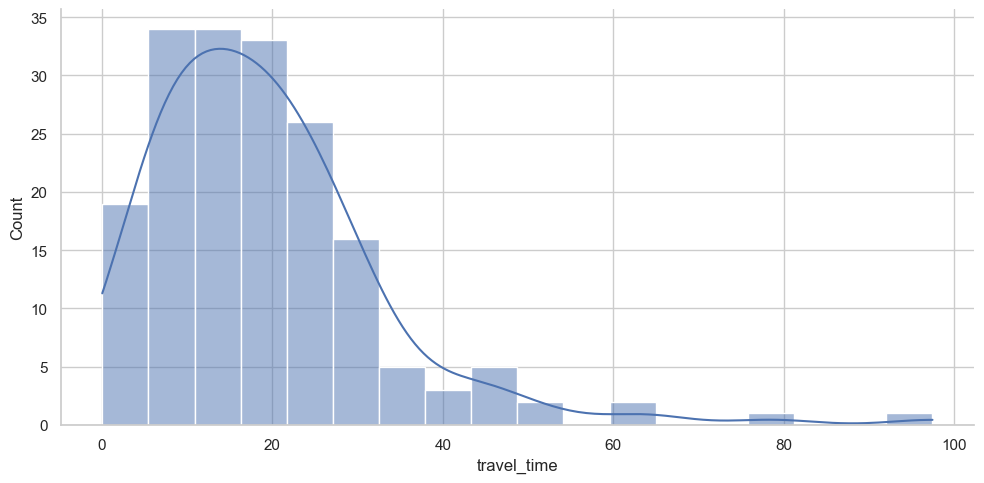

In [21]:
# plot bar chart of travel times
sns.set_theme(style="whitegrid")
ax = sns.displot(data_store, x="travel_time", fill=True, kde=True, height=5, aspect=2)